In [13]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [19]:
# # Label remapping
# label_map = {
#     'alert': 'alert', 'Not drowsy': 'alert', 'Not Drowsy': 'alert',
#     'Slightly drowsy': 'slightly', 'Slightly Drowsy': 'slightly', 'slightly': 'slightly',
#     'Moderately drowsy': 'very', 'Moderately Drowsy': 'very', 'Very drowsy': 'very',
#     'very': 'very', 'moderately': 'very'
# }

# label_map = {
#     'Not Drowsy': 'alert', 'Slight': 'slightly', 'Moderate': 'moderate_very', 'Very': 'moderate_very'
# }

label_map = {
    'Not Drowsy': 'alert', 'Slight': 'drowsy', 'Moderate': 'drowsy', 'Very': 'drowsy'
}

# Feature list
# features = [
#     'EAR_mean', 'MAR_inner', 'MAR_outer',
#     'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r',
#     'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz',
#     'gaze_angle_x', 'gaze_angle_y',
#     'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed'

# features = [
#     'EAR_mean_mean', 'MAR_inner_mean', 'MAR_outer_mean', 'AU01_r_mean', 'AU15_r_mean', 'AU25_r_mean', 'AU26_r_mean',
#     'AU45_r_mean', 'pose_Tx_mean', 'pose_Ty_mean', 'pose_Tz_mean', 'pose_Rx_mean', 'pose_Ry_mean', 'pose_Rz_mean',
#     'gaze_angle_x_mean', 'gaze_angle_y_mean', 'swAngle_mean', 'laneDevPosition_mean', 'laneDev_OffsetfrmLaneCentre_mean',
#     'speed_mean', 'EAR_mean_std', 'MAR_inner_std', 'MAR_outer_std', 'AU01_r_std', 'AU15_r_std',
#     'AU25_r_std', 'AU26_r_std', 'AU45_r_std', 'pose_Tx_std', 'pose_Ty_std', 'pose_Tz_std', 'pose_Rx_std', 'pose_Ry_std',
#     'pose_Rz_std', 'gaze_angle_x_std', 'gaze_angle_y_std', 'swAngle_std', 'laneDevPosition_std',
#     'laneDev_OffsetfrmLaneCentre_std', 'speed_std'
# ]

features = [ 'EAR_mean_mean', 'EAR_mean_std',
    # 'MAR_inner_mean', 'MAR_inner_std',
    # 'MAR_outer_mean', 'MAR_outer_std',
    'pose_Tx_mean', 'pose_Ty_mean', 'pose_Tz_mean', 'pose_Rx_mean', 'pose_Ry_mean', 'pose_Rz_mean', 
    'pose_Tx_std', 'pose_Ty_std', 'pose_Tz_std', 'pose_Rx_std', 'pose_Ry_std', 'pose_Rz_std'
]

📊 Class distribution in training set BEFORE SMOTE:
  drowsy: 7316 samples
  alert: 1633 samples

📊 Class distribution in test set:
  drowsy: 1500 samples
  alert: 535 samples

📊 Class distribution in training set AFTER SMOTE:
  alert: 7316 samples
  drowsy: 7316 samples


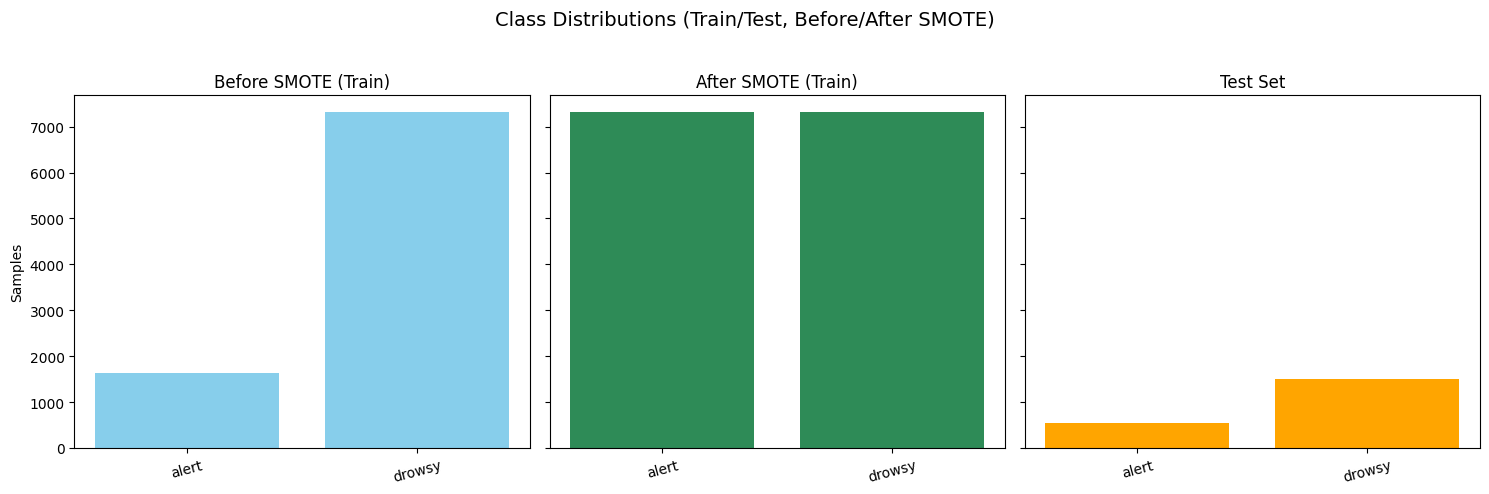

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# --- Load datasets ---
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')
# train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data_noOverlap.csv')
# test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data_noOverlap.csv')

# --- Map and clean labels ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# --- Extract features and labels ---
X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# --- Encode string labels to integers ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- Class distribution BEFORE SMOTE ---
print("📊 Class distribution in training set BEFORE SMOTE:")
before_counts = y_train.value_counts()
for label, count in before_counts.items():
    print(f"  {label}: {count} samples")

# --- Class distribution in TEST set ---
print("\n📊 Class distribution in test set:")
test_counts = y_test.value_counts()
for label, count in test_counts.items():
    print(f"  {label}: {count} samples")

# --- Apply SMOTE ---
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

# --- Class distribution AFTER SMOTE ---
y_train_labels_sm = le.inverse_transform(y_train_sm)
after_counts = pd.Series(y_train_labels_sm).value_counts()

print("\n📊 Class distribution in training set AFTER SMOTE:")
for label, count in after_counts.items():
    print(f"  {label}: {count} samples")

# --- Custom label order (if you want consistent axis order) ---
all_labels = sorted(set(before_counts.index).union(after_counts.index).union(test_counts.index))

# --- Reindex for plotting ---
before_counts = before_counts.reindex(all_labels, fill_value=0)
after_counts = after_counts.reindex(all_labels, fill_value=0)
test_counts = test_counts.reindex(all_labels, fill_value=0)

# --- Plot 1×3 comparison ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Before SMOTE
axes[0].bar(before_counts.index, before_counts.values, color='skyblue')
axes[0].set_title("Before SMOTE (Train)")
axes[0].set_ylabel("Samples")
axes[0].tick_params(axis='x', rotation=15)

# After SMOTE
axes[1].bar(after_counts.index, after_counts.values, color='seagreen')
axes[1].set_title("After SMOTE (Train)")
axes[1].tick_params(axis='x', rotation=15)

# Test Set
axes[2].bar(test_counts.index, test_counts.values, color='orange')
axes[2].set_title("Test Set")
axes[2].tick_params(axis='x', rotation=15)

plt.suptitle("Class Distributions (Train/Test, Before/After SMOTE)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Dummy Classifier:

              precision    recall  f1-score   support

       alert       0.27      0.19      0.22       535
      drowsy       0.74      0.82      0.78      1500

    accuracy                           0.65      2035
   macro avg       0.50      0.50      0.50      2035
weighted avg       0.62      0.65      0.63      2035



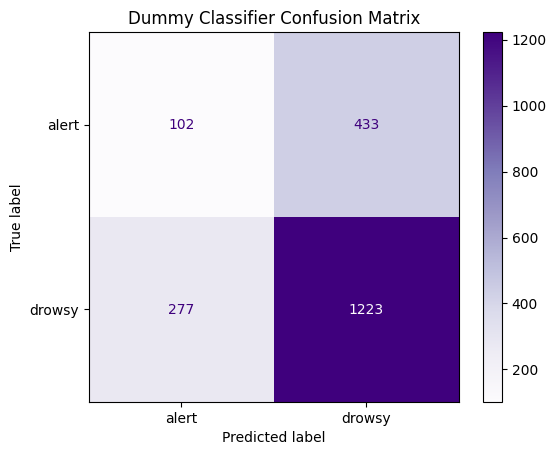

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Load CSVs
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')
# train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data_noOverlap.csv')
# test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data_noOverlap.csv')

# Apply mapping
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

# Drop rows with unmapped labels
train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# Feature list
features = [col for col in train_df.columns if col != 'Label']

# Extract features and labels
X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Fit dummy classifier
dummy_clf = DummyClassifier(strategy='stratified')  
dummy_clf.fit(X_train, y_train_enc)

# Predict
y_pred_dummy = dummy_clf.predict(X_test)

# Define custom order
custom_order = ['alert', 'drowsy']  # Adjust based on your actual labels
custom_label_indices = [list(le.classes_).index(lbl) for lbl in custom_order]

# Classification report
print("Dummy Classifier:\n")
print(classification_report(
    y_test_enc,
    y_pred_dummy,
    labels=custom_label_indices,
    target_names=custom_order
))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_dummy,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Purples'
)
plt.title("Dummy Classifier Confusion Matrix")
plt.show()

Random Forest Grid Search: 240it [02:57,  1.35it/s]                       

Random Forest:

              precision    recall  f1-score   support

       alert       0.60      0.08      0.14       535
      drowsy       0.75      0.98      0.85      1500

    accuracy                           0.74      2035
   macro avg       0.68      0.53      0.49      2035
weighted avg       0.71      0.74      0.66      2035

Balanced F1 Score (macro): 0.4929
Balanced F1 Score (weighted): 0.6621
ROC AUC: 0.7021


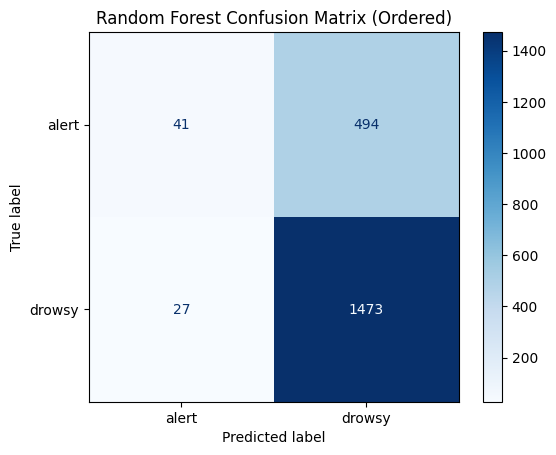

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from tqdm import tqdm
import joblib
from contextlib import contextmanager

# --- tqdm-joblib context manager ---
@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

# --- Load datasets ---
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')

# --- Map and clean labels ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)
train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# --- Remove non-feature columns ---
non_features = ['ID', 'Study', 'window_start', 'Label']
features = [col for col in train_df.columns if col not in non_features]

# --- Split features and labels ---
X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# --- Encode labels ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- Balance training set with SMOTE ---
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

# --- Grid Search Parameters ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)

# --- Run GridSearch with Progress Bar ---
with tqdm_joblib(tqdm(desc="Random Forest Grid Search", total=np.prod([len(v) for v in param_grid.values()]))):
    grid_search.fit(X_train_sm, y_train_sm)

rf_model = grid_search.best_estimator_

# --- Predict ---
y_pred_rf = rf_model.predict(X_test)

# --- Probabilities ---
unique_labels = np.unique(y_test_enc)
if len(unique_labels) == 2:
    y_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # binary
else:
    y_proba_rf = rf_model.predict_proba(X_test)        # multiclass

# --- Custom label order ---
custom_order = ['alert', 'drowsy']
custom_label_indices = [list(le.classes_).index(lbl) for lbl in custom_order]

# --- Classification Report ---
print("Random Forest:\n")
print(classification_report(
    y_test_enc,
    y_pred_rf,
    labels=custom_label_indices,
    target_names=custom_order
))

# --- Balanced F1 Scores ---
f1_macro = f1_score(y_test_enc, y_pred_rf, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred_rf, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")

# --- ROC AUC ---
if len(unique_labels) == 2:
    auc_score = roc_auc_score(y_test_enc, y_proba_rf)
else:
    auc_score = roc_auc_score(y_test_enc, y_proba_rf, multi_class='ovr', average='macro')
print(f"ROC AUC: {auc_score:.4f}")

# --- Confusion Matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_rf,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Blues'
)
plt.title("Random Forest Confusion Matrix (Ordered)")
plt.show()

XGBoost Grid Search: 160it [00:11, 13.89it/s]                       

XGBoost:

              precision    recall  f1-score   support

       alert       0.44      0.16      0.23       535
      drowsy       0.76      0.93      0.83      1500

    accuracy                           0.73      2035
   macro avg       0.60      0.54      0.53      2035
weighted avg       0.67      0.73      0.67      2035

Balanced F1 Score (macro): 0.5309
Balanced F1 Score (weighted): 0.6741
ROC AUC: 0.6779


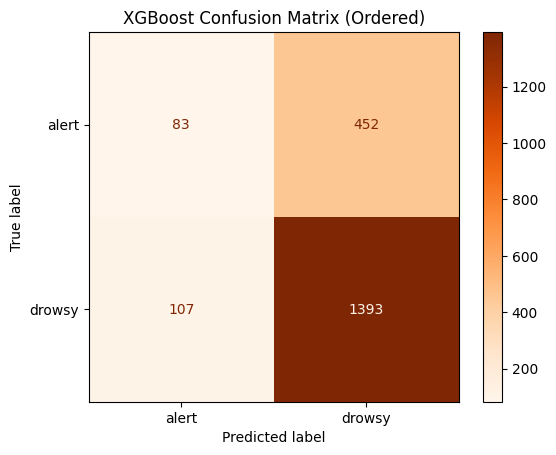

In [22]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import joblib
from contextlib import contextmanager

# --- tqdm-joblib context manager ---
@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

# --- Load datasets ---
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')
# train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data_noOverlap.csv')
# test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data_noOverlap.csv')

# --- Map and clean labels ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# --- Remove non-feature columns ---
non_features = ['ID', 'Study', 'window_start', 'Label']
features = [col for col in train_df.columns if col not in non_features]

# --- Split features and labels ---
X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# --- Encode labels ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- Balance training set with SMOTE ---
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

# --- Grid search parameters ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'reg_alpha': [0, 0.1],       # L1 regularization
    'reg_lambda': [1, 2],        # L2 regularization
    'subsample': [0.8],          # optional
    'colsample_bytree': [0.8]    # optional
}

base_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# --- Run GridSearch with progress bar ---
with tqdm_joblib(tqdm(desc="XGBoost Grid Search", total=np.prod([len(v) for v in param_grid.values()]))):
    grid_search.fit(X_train_sm, y_train_sm)

xgb_model = grid_search.best_estimator_

# --- Predict ---
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]  # ✅ prob for positive class

# --- Define custom label order ---
custom_order = ['alert', 'drowsy']
custom_label_indices = [list(le.classes_).index(lbl) for lbl in custom_order]

# --- Classification report ---
print("XGBoost:\n")
print(classification_report(
    y_test_enc,
    y_pred_xgb,
    labels=custom_label_indices,
    target_names=custom_order
))

# --- Balanced F1 Score ---
f1_macro = f1_score(y_test_enc, y_pred_xgb, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred_xgb, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")

# --- ROC AUC ---
unique_labels = np.unique(y_test_enc)

if len(unique_labels) == 2:
    auc_score = roc_auc_score(y_test_enc, y_proba_xgb)
else:
    auc_score = roc_auc_score(y_test_enc, xgb_model.predict_proba(X_test),
                              multi_class='ovr', average='macro')
print(f"ROC AUC: {auc_score:.4f}")

# --- Confusion matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_xgb,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Oranges'
)
plt.title("XGBoost Confusion Matrix (Ordered)")
plt.show()

MLP Grid Search:   0%|          | 0/540 [00:00<?, ?it/s]/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 5 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
MLP Grid Search:   1%|          | 4/540 [00:03<06:17,  1.42it/s]/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_

MLP:

               precision    recall  f1-score   support

        alert       0.52      0.51      0.51       535
     slightly       0.62      0.48      0.54       822
moderate_very       0.58      0.74      0.65       678

     accuracy                           0.58      2035
    macro avg       0.57      0.58      0.57      2035
 weighted avg       0.58      0.58      0.57      2035

Balanced F1 Score (macro): 0.5683
Balanced F1 Score (weighted): 0.5702
ROC AUC: 0.7483


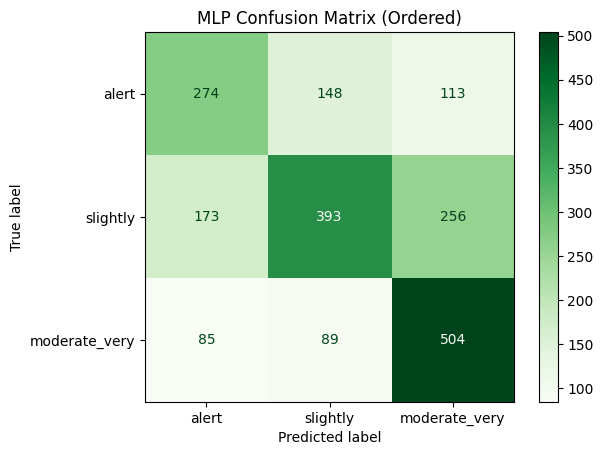

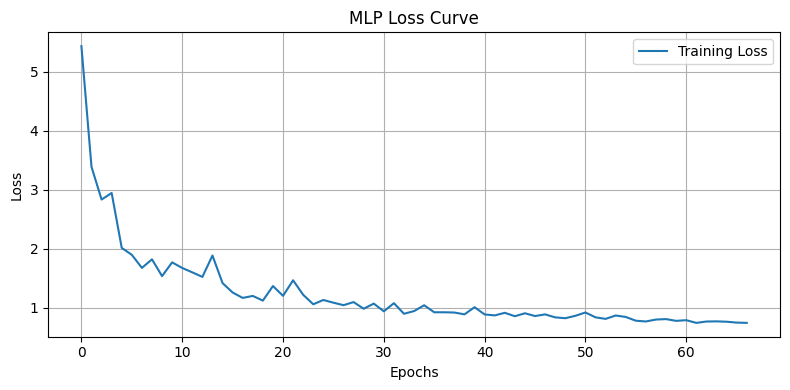

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
from contextlib import contextmanager

# --- tqdm-joblib progress bar for GridSearchCV ---
@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

# --- Load datasets ---
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')

# --- Label mapping (you must define `label_map`) ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)
train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# --- Feature selection ---
non_features = ['ID', 'Study', 'window_start', 'Label']
features = [col for col in train_df.columns if col not in non_features]
X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# --- Encode labels ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- Balance with SMOTE ---
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

# --- Grid Search ---
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64), (256, 128)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],              # L2 regularization strength
    'learning_rate_init': [0.0005, 0.001, 0.01], # Learning rate
    'batch_size': [32, 64, 128],                 # Batch sizes
    'max_iter': [300],                           # More iterations for convergence
}

base_model = MLPClassifier(
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=15,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# --- Run GridSearch with progress bar ---
with tqdm_joblib(tqdm(desc="MLP Grid Search", total=np.prod([len(v) for v in param_grid.values()]))):
    grid_search.fit(X_train_sm, y_train_sm)

mlp = grid_search.best_estimator_

# --- Predict ---
y_pred_mlp = mlp.predict(X_test)
y_proba_mlp = mlp.predict_proba(X_test)[:, 1]  # ✅ probability for positive class

# --- Custom label order ---
custom_order = ['alert', 'slightly', 'moderate_very']
custom_label_indices = [list(le.classes_).index(lbl) for lbl in custom_order]

# --- Classification report ---
print("MLP:\n")
print(classification_report(
    y_test_enc,
    y_pred_mlp,
    labels=custom_label_indices,
    target_names=custom_order
))

# --- Balanced F1 Score ---
f1_macro = f1_score(y_test_enc, y_pred_mlp, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred_mlp, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")

# --- ROC AUC ---
unique_labels = np.unique(y_test_enc)
if len(unique_labels) == 2:
    auc_score = roc_auc_score(y_test_enc, y_proba_mlp)
else:
    auc_score = roc_auc_score(y_test_enc, mlp.predict_proba(X_test),
                              multi_class='ovr', average='macro')
print(f"ROC AUC: {auc_score:.4f}")

# --- Confusion matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_mlp,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Greens'
)
plt.title("MLP Confusion Matrix (Ordered)")
plt.show()

# --- Loss curve ---
plt.figure(figsize=(8, 4))
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.title("MLP Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()